In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize

import copy



In [2]:
import gc
gc.collect()

0

In [3]:

import os
os.chdir("C:/Users/Meredith/Documents/GitHub/LDI-ML/")

In [4]:
fp = "MACHINE_LEARNING_PART/"
df = pd.read_csv(f"{fp}ARMA_output_Price.csv", index_col=0)
df_vol = pd.read_csv(f"{fp}ARMA_output_Volume.csv", index_col=0)

# Calculate Standard Deviation
df['Std'] = (df.value - df.lower)/1.96
df.loc[(df.lower==0)&(df.upper==0),'Std'] = 0

In [5]:
def price(t, x, start=None, seed=None):
    if start is None:
        # Use best possible predictions by default
        start = max(df.start)
    if seed is None:
        # Return the predicted price
        return np.maximum(df.loc[df.start==start, :].loc[t, 'value'].values, np.zeros_like(t))

    # Return a random variable generated using the predicted price and the standard deviation
    rng= np.random.default_rng(seed)
    return  np.maximum(rng.normal(loc=df.loc[df.start==start, :].loc[t, 'value'].values, scale=df.loc[df.start==start, :].loc[t, 'Std'].values), np.zeros_like(t))
    

def volume(t, x, start=None, seed=None):
    if start is None:
        # Use best possible predictions by default
        start = max(df.start)

    if seed is None:
        # Return the predicted volume
        return np.maximum(df_vol.loc[df_vol.start==start, :].loc[t, 'value'].values, np.zeros_like(t))
    # Return a random variable generated using the predicted volume and the standard deviation
    rng= np.random.default_rng(seed)
    return  np.maximum(rng.normal(loc=df_vol.loc[df_vol.start==start, :].loc[t, 'value'].values, scale=df.loc[df_vol.start==start, :].loc[t, 'Std'].values), np.zeros_like(t))

def cost(V, t, x, start=None,seed=None):
    # Calculate the cost
    if start is None:
        # Use best possible predictions by default
        start = max(df.start)
    return np.dot(V, price(t, x, start, seed=seed))

def target_volume(V, target_V):
    # If negative, the target has not been met
    return np.sum(V) - target_V

def set_target_volume(t, x, ratio=0.5):
    # Set an achievable target volume
    total_V = np.sum(volume(t, x))
    target_V = total_V*ratio
    return target_V



Text(0, 0.5, 'Predicted Volume (ML)')

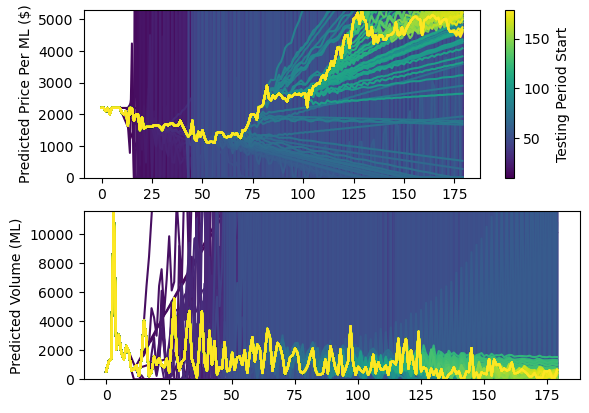

In [10]:
import matplotlib as mpl
from matplotlib import cm

# Plot the predicted volume and price at different starting points for the model                
t = df.index.unique()
x = []

fig, ax = plt.subplots(2)

# Set up for consistent colour mapping
norm = mpl.colors.Normalize(vmin=min(df.start.unique()), vmax=max(df.start.unique()))
map = cm.ScalarMappable(norm=norm, cmap='viridis')

# Plotting the data for different starts
for start in df.start.unique():
    ax[0].plot(t, price(t, x, start), c=map.get_cmap()(norm(start)))
    ax[1].plot(t, volume(t, x, start), c=map.get_cmap()(norm(start)))


# Formatting plot
plt.colorbar(map,ax=ax[0], label="Testing Period Start")

ax[0].set_ylim(0, max(price(t, x, start=max(df.start))))
ax[0].set_ylabel("Predicted Price Per ML ($)")
ax[1].set_ylim(0, max(volume(t, x, start=max(df.start))))
ax[1].set_ylabel("Predicted Volume (ML)")


In [24]:
import scipy
class regression:
    def __init__(self, x, y):
        
        res = scipy.stats.linregress(x, y)
        #res = np.polynomial.polynomial.Polynomial.fit(x, y, 1)
        slope, intercept = res.slope, res.intercept
        #intercept, slope = res.convert().coef
        self.intercept = intercept
        self.slope = slope

In [43]:
def manual_receding(V, t, target_V, start,x, stop_val=0, seed=None):
    # Treat as simple LP, find lowest prices and exploit. No consideration of uncertainty
    V_needed = target_V
   # for 
    P = price(t, x, start=start, seed=seed)
    Vol = volume(t, x, start=start, seed=seed)
    return go_receding(V, t, target_V, P, Vol, stop_val=stop_val)

# def go_receding(V, t, target_V, P, Vol, stop_val=0):
#     V_needed = target_V
#     order = np.argsort(P)

#     k=0
#     while V_needed > 0:
#         t_best = t[order[k]]
#         V[order[k]] = np.minimum(V_needed, Vol[order[k]])
#         V_needed -= V[order[k]]

#         if order[k]==stop_val:
#             break # don't need to calculate the rest
#         k+=1
#         if (k == len(order)):
#             print('Optimisation failed')
#             break
#     return V

def go_receding(V, t, target_V, P, Vol, stop_val=0):
    V_needed = target_V
    order = np.argsort(P)

    k=0
    last_order = np.argwhere(order==stop_val)
    if len(last_order)==0:
        last_order = len(P)

    for k in np.arange(last_order+1):
        t_best = t[order[k]]
        V[order[k]] = np.minimum(V_needed, Vol[order[k]])
        V_needed -= V[order[k]]

        if V_needed <=0:
            break # don't need to calculate the rest
        
  #  if np.sum(Vol)<V_needed:
   #     print('Optimisation failed')
    return V

def pick_random(V, t, target_V, start,x, stop_val=0, seed=None):
    # Function to simulate decision being made randomly
    V_needed = target_V
    Vol = volume(t, x, start=start, seed=seed)
   # Vol[1:]=np.random.uniform(0, 1, size=len(Vol)-1)
    # Instead of starting with lowest price, choose order based on a random variable

    return go_receding(V, t, target_V, np.random.uniform(0, 1, size=len(Vol)), Vol, stop_val=stop_val)

def regress(V, t, target_V, start,x, stop_val=0, seed=None, max_val = 50000):
    starts = df.start.unique()[df.start.unique()<=start]
    Ps = np.empty((len(t), len(starts)))
    Vs = np.empty((len(t), len(starts)))
    for k, start_i in enumerate(starts):
     #   Ps[:, k] = np.maximum(price(t, x, start=start_i, seed=seed), max_val)
        Ps[:, k] = np.minimum(price(t, x, start=start_i, seed=seed), max_val)
        Vs[:, k] = volume(t, x, start=start_i, seed=seed)

    P = np.empty_like(t)
    Vol = np.empty_like(t)
    for j in range(len(t)):
        try:
            # Linear regression on previous predictions for this time
            res = regression(starts, Ps[j, :])
            P[j] = np.sign(res.slope)*np.minimum(abs(res.slope), 100)*(max(t)+1)+res.intercept
            res = regression(starts, Vs[j, :])
            Vol[j] = res.slope*(max(t)+1)+res.intercept
            
        except:
            # Numbers can get too large and cause overflow errors. Setting to 0 ignores these in the algorithm
            P[j] = 0
            Vol[j] = 0
            
    P[0] = price(t, x, start=start, seed=seed)[0]
    Vol[0] = volume(t, x, start=start, seed=seed)[0]
    return go_receding(V, t, target_V, P, Vol, stop_val=stop_val)

def pessimistic(V, t, target_V, start,x, stop_val=0, seed=None):
    P = np.zeros_like(t)
    Vol = np.zeros_like(t)
    P[0] = price(t, x, start=start, seed=seed)[0]
    Vol[0] = volume(t, x, start=start, seed=seed)[0]
    return go_receding(V, t, target_V, P, Vol, stop_val=stop_val)


def run_receding(t, x, target_V, stop_val=0, report=True, report_name="Simple Approach", func=manual_receding, seed=None, func_kwargs={}):

    V = np.zeros_like(t, dtype=np.float64)
    for i in range(len(t)):
        t_window = t[i:]
        V_window = np.zeros_like(t_window, dtype=np.float64)
        V[i] = func(V_window, t_window, target_V-np.sum(V), t[i]+1,x, stop_val=stop_val, seed=seed, **func_kwargs)[0]
    if report:
        report_outcome(V, t, x, tv=target_V, name=report_name, seed=seed)
    return V

def report_outcome(V, t, x, start=None, tv=None, ratio=0.5, name="Run", seed=None):
    if start is None:
        start = max(t)+1
        start = max(df.start.unique())
    if target_volume is None:
        tv = tv(t, x, ratio=ratio)

    print(name)

    if sum(V) < tv:
        print("\t Failed to meet target volume")
    total_cost = cost(V, t, x, start, seed=seed)
    print(f"\t Total Cost: ${total_cost:,.2f}")

    return total_cost

In [26]:
t = df.start.unique()[:-1] # Exclude last point to use as ground truth

target_V = set_target_volume(t, x, ratio=0.8)
V = run_receding(t, x, target_V)

V_best = manual_receding(np.zeros_like(t, dtype=np.float64), t, start=max(df.start), target_V=target_V, x=x, stop_val=max(t)+1)
report_outcome(V_best, t, x, tv=target_V, name="Actual Best")

Simple Approach
	 Failed to meet target volume
	 Total Cost: $366,142,636.96
Actual Best
	 Total Cost: $290,482,388.92


In [48]:
def plot_decisions(V,t, x, ax):
    # Plot volume available against the volume purchased
    ax.plot(t, volume(t, x,max(df.start)), label="Volume available")
    ax.bar(t, V, color='C1', label="Volume purchased")

    # Add price on secondary axis
    ax2= ax.twinx()
    ax2.fill_between(t, 0, price(t, x,max(df.start)), fc='lavender', zorder=0)
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False) 

    # Formatting
    yl = ax2.get_ylim()
    ax2.set_ylim(0, yl[1])
    ax2.set_ylabel('Price per ML ($)')
    ax.set_ylabel("Volume (ML)")
    ax.set_xlabel("Month")

def plot_cumulative(V, t, x, tv, ax, show_target=True, fstring="Target Volume = {target:,.2f}ML", ylabel= "Total Volume (ML)", label=None):
    ax.plot(t, np.cumsum(V), label=label)

    if show_target:
        ax.axhline(tv, c='k', ls='--')
        #ax.text(np.mean(t), tv, f'Target Volume = {tv:,.2f}ML', va='bottom', ha='center')
        ax.text(np.mean(t), tv, fstring.format(target=tv), va='bottom', ha='center')
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Month")

    ax.set_ylim([0, None])

In [55]:
def compare_results(t, x, target_V, funcs, names, seed=None):
    fig, ax = plt.subplots(1+len(funcs), 2, figsize=(10, 5*(1+len(funcs))))

    fig2, ax2 = plt.subplots(2)
    P = price(t, x, start, seed=seed)
    
    V_best = manual_receding(np.zeros_like(t, dtype=np.float64), t, start=max(df.start), target_V=target_V, x=x, stop_val=max(t)+1)
    tc= report_outcome(V_best, t, x, tv=target_V, name="Actual Best")
    ax[0, 0].title.set_text("Theoretical Best")
    plot_decisions(V_best, t, x, ax[0, 0])
    plot_cumulative(V_best, t,x, target_V, ax[0, 1])
    plot_cumulative(V_best, t,x, target_V, ax2[0], label="Theoretical Best")
    plot_cumulative(np.multiply(V_best, P), t,x, tc, ax2[1], fstring="Best Cost ${target:,.2f}", label="Theoretical Best")

    for i, (func, name) in enumerate(zip(funcs, names)):
        V = run_receding(t, x, target_V, func=func, report_name=name)
        ax[1+i, 0].title.set_text(name)
        plot_decisions(V, t, x, ax[1+i, 0])
        plot_cumulative(V, t,x, target_V, ax[1+i, 1])
        plot_cumulative(V, t,x, target_V, ax2[0], show_target=False, label=name)
        plot_cumulative(np.multiply(V, P), t,x, tc, ax2[1], show_target=False, ylabel="Cost ($)", label=name)
    
    ax2[1].legend()
    fig2.tight_layout()
    fig.tight_layout()

    return fig

Actual Best
	 Total Cost: $290,482,388.92
Rolling Optimisation
	 Failed to meet target volume
	 Total Cost: $366,142,636.96
Regressive Optimisation
	 Total Cost: $393,139,910.81
Pessimistic Optimisation
	 Total Cost: $291,229,892.37


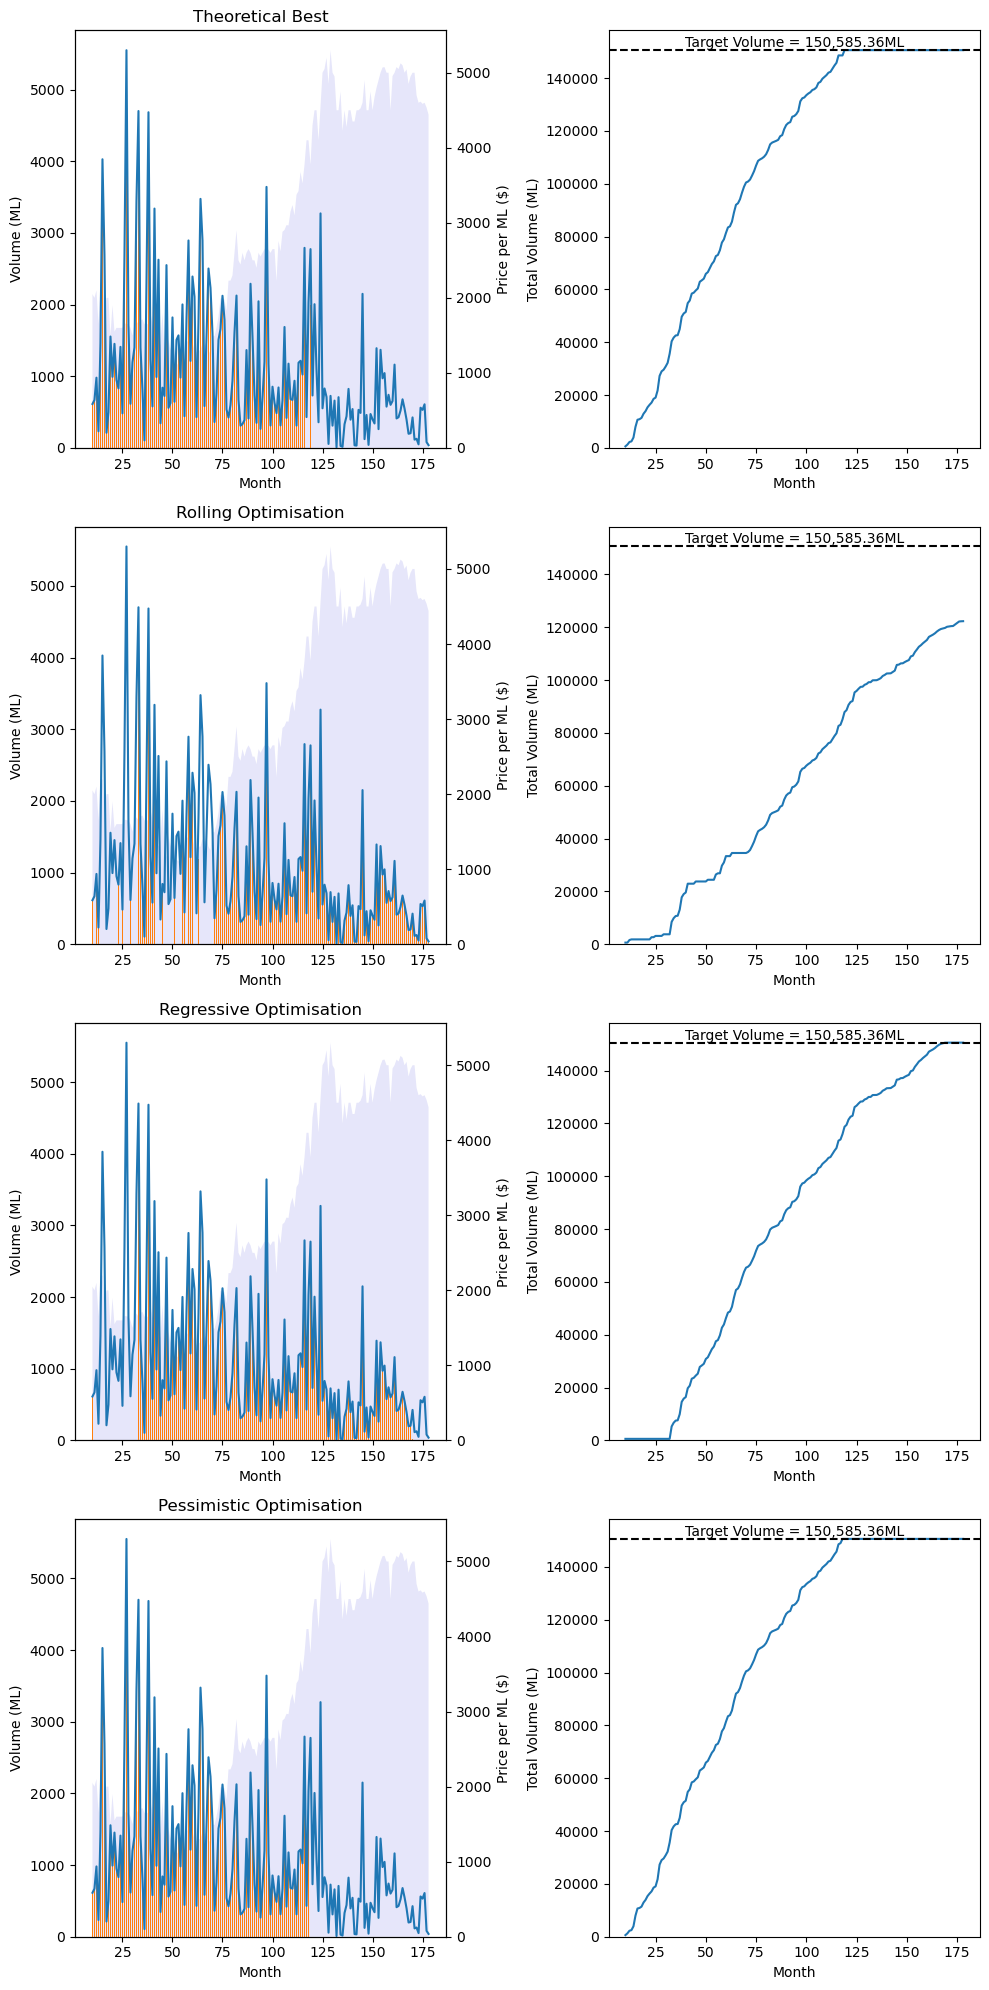

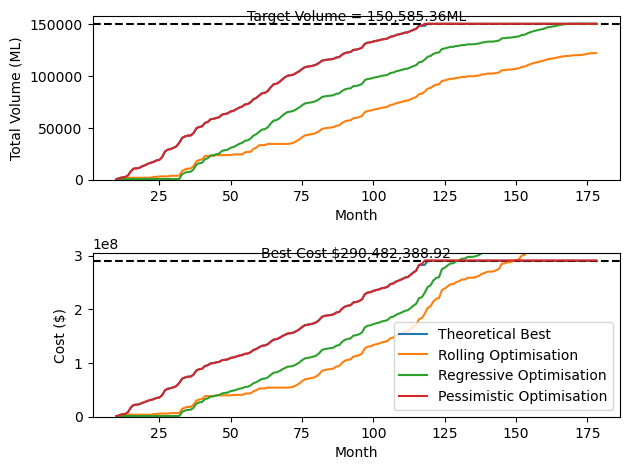

In [56]:
fig = compare_results(t, x, target_V, [manual_receding, regress, pessimistic], ["Rolling Optimisation", "Regressive Optimisation", "Pessimistic Optimisation"])

Simple Approach
	 Failed to meet target volume
	 Total Cost: $366,142,636.96
Actual Best
	 Total Cost: $290,482,388.92
Regressive Optimisation
	 Total Cost: $393,139,910.81


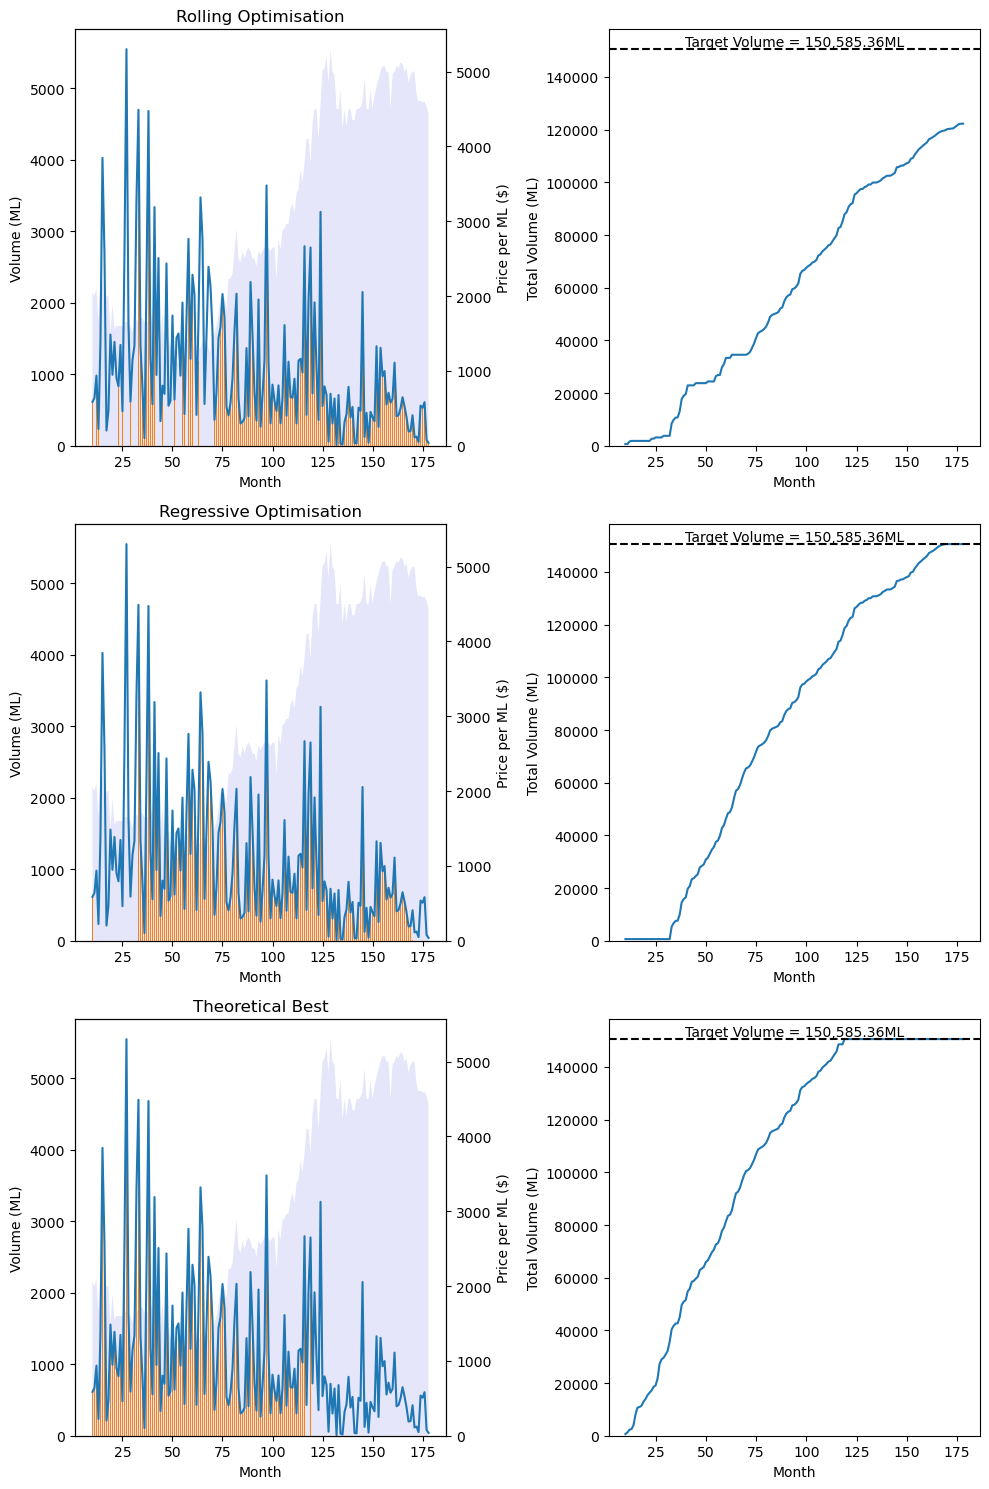

In [30]:
t = df.start.unique()[:-1] # Exclude last point to use as ground truth

target_V = set_target_volume(t, x, ratio=0.8)
V = run_receding(t, x, target_V)

V_best = manual_receding(np.zeros_like(t, dtype=np.float64), t, start=max(df.start), target_V=target_V, x=x, stop_val=max(t)+1)
report_outcome(V_best, t, x, tv=target_V, name="Actual Best")

fig, ax = plt.subplots(3, 2, figsize=(10, 15))
ax[0, 0].title.set_text("Rolling Optimisation")
plot_decisions(V, t, x, ax[0, 0])
plot_cumulative(V, t,x, target_V, ax[0, 1])

V = run_receding(t, x, target_V, func=regress, report_name="Regressive Optimisation")
ax[1, 0].title.set_text("Regressive Optimisation")
plot_decisions(V, t, x, ax[1, 0])
plot_cumulative(V, t,x, target_V, ax[1, 1])

ax[2, 0].title.set_text("Theoretical Best")
plot_decisions(V_best, t, x, ax[2, 0])
plot_cumulative(V_best, t,x, target_V, ax[2, 1])

fig.tight_layout()

fig.savefig("OptimisationResults.png", dpi=300)




In [75]:
iterations = 10

# Run for a number of iterations with randomness and see distribution of results 

funcs = [pick_random, manual_receding, regress]
Vs= np.empty((t.shape[0], iterations, len(funcs)))
Vs[:] = np.nan
Cs=np.empty((iterations, len(funcs)))
Cs[:] = np.nan

for it in np.arange(iterations):
    for func_i, func in enumerate(funcs):
        V = run_receding(t, x, target_V, seed=it, report=False, func=func)
        if sum(V) >= target_V:
            Vs[:, it, func_i] = V
            Cs[it, func_i] = cost(V, t, x, start=max(df.start))


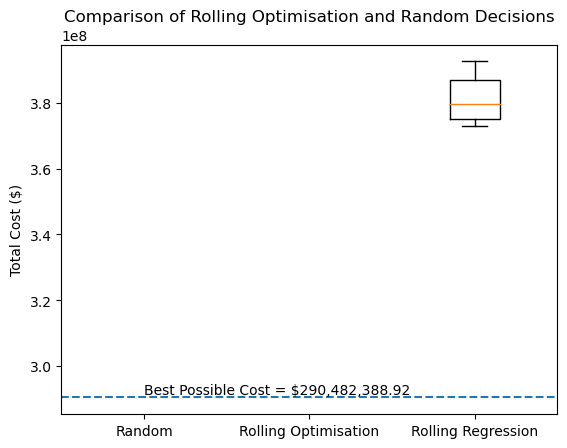

In [76]:
fig, ax = plt.subplots()
ax.boxplot([Cs[:, i] for i in range(Cs.shape[-1])])

best_cost = cost(V_best, t, x)
ax.axhline(best_cost, ls='--')
ax.text(1, best_cost, f'Best Possible Cost = ${best_cost:,.2f}', va='bottom')
ax.set_xticks([1, 2, 3], labels=["Random", "Rolling Optimisation", "Rolling Regression"])

ax.set_ylabel("Total Cost ($)")
ax.title.set_text('Comparison of Rolling Optimisation and Random Decisions')

plt.savefig("Rolling vs Random.png", dpi=300)

In [19]:
from numba import jit

In [19]:
seed = None
max_val = 50000
start_i = 20

Ps = np.minimum(price(t, x, start=start_i, seed=seed), max_val)
Vs = volume(t, x, start=start_i, seed=seed)

In [52]:
coefs = regression(t, Ps)

In [53]:
coefs.intercept

6273.450971922384

In [54]:
coefs.slope

136.41945450831196

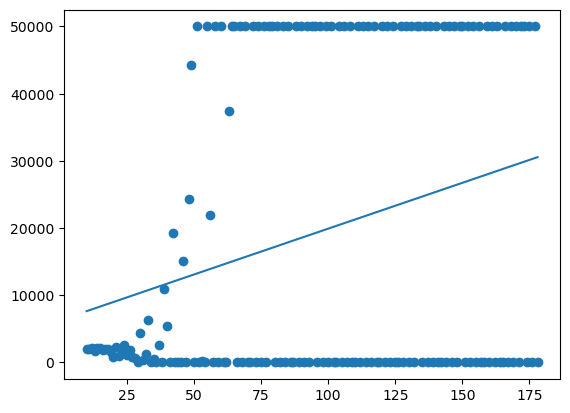

In [55]:
plt.scatter(t, Ps)
plt.plot(t, t*coefs.slope + coefs.intercept)

In [64]:
y=np.vstack([Ps, Vs]).T

In [65]:
coefs = np.polynomial.polynomial.Polynomial.fit(t, y, 1)

ValueError: Coefficient array is not 1-d

ValueError: x and y must be the same size

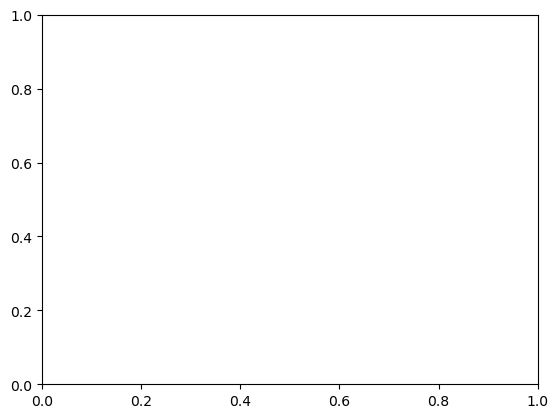

In [62]:
plt.scatter(t, y)
plt.plot(t, t*coefs.coef[1] + coefs.coef[0])

In [48]:
coefs.identity()

Polynomial([0., 1.], domain=[-1.,  1.], window=[-1.,  1.])

In [50]:
coefs.convert().coef

array([6273.45097192,  136.41945451])